# T036 · Uncertainty estimation

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Michael Backenköhler, 2022, [Volkamer lab](https://volkarmerlab.org), Saarland University

*The predictive setting (and the model calss) used in this talktorial is adapted from [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb).*

## Aim of this talktorial

Add a short summary of this talktorial's content.

### Contents in *Theory*

* Why a model can't and shouldn't be certain
* Calibration
* Methods overview
    * Single deterministic methods
    * Ensemble methods
* Specific aspects im cheminformatics

### Contents in *Practical*
* Model
    * Training
    * Evaluation
* Ensembles - Training a model multiple times
    * Coverage of confidence intervals
    * Calibration
    * Ranking based evaluation
* Bagging ensemble - Training a model with varying data
    * Coverage of confidence intervals
    * Calibration
    * Ranking based evaluation

### References
* [Gawlikowski, Jakob, et al. "A survey of uncertainty in deep neural networks." _arXiv preprint_ (2021), arXiv:__2107.03342__](https://arxiv.org/abs/2107.03342)
* [Scalia, Gabriele, et al. "Evaluating scalable uncertainty estimation methods for deep learning-based molecular property prediction." _Journal of chemical information and modeling_ __60.6__ (2020): 2697-2717](https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.9b00975)
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb)

## Theory
Often researchers pay a lot of attention to the quality of the estimation overall.
But to apply any predictive method in practice, it is arguably as important to know how much to _trust_ an estimation.
It would be therefore nice to have not only a point estimate of something but also some indication of how _certain_ we can be about the given estimate.
The certainty is often modeled by replacing the point estimate by a distributional estimate.
For example, a model $f$ on an input does not only predict $f(x)=\hat\theta$ but a normal distribution $f(x)=N(\hat\theta, \hat\sigma)$.

### Why a model can't and shouldn't be certain
Before discussing how to estimate uncertainty, we take a look at the causes of uncertainty.
These are twofold:
1. _Aleatoric_ or _data uncertainty_ is inherent in the data and its source
2. _Epistemic_ or _model uncertainty_ is caused by the limitations of the model
Aleatoric uncertainty is unavoidable because it is inherent in the real system and the way we collect data.
It is uncertainty that remains even if can select infinitely large sets of data.
Imagine you are performing a chemical experiment to determine the binding affinity between some compound and a protein.
Even if you are an outstandingly careful chemist you will probably not be able to exactly reproduce the same $K_d$ each time around.
This uncertainty will always be present in the data. Even if you repeat the experiment until you reach old age.

Model uncertainty is caused by the abstraction our model makes. Our models are not perfect. If they were, we would not need machine learning after all!
Thus, we always introduce some degree of simplification. And this introduces uncertainty into our predictions.

### Calibration

### Methods overview
There is a wide variety of methods providing uncertainty estimates. An excellent survey is given in ___REF___.
Here, we stick with the most common and widely applicable methods.
These can roughly be divided into
1. single deterministic methods and
2. ensemble methods.

#### Single deterministic methods

#### Ensemble methods
Ensemble methods are based on the idea of creating a selection, i.e. an ensemble, of similar but different models. As a simple example of such an ensemble consider a neural network model, that is trained multiple times. Due to the inherent randomness in the stochastic gradient descent, each trained version of the model will differ from the others.

![Model ensemble](images/nn.png)

*Figure 1:* 
An ensemble of similar models with different weights obtained by multiple varying training runs.

This difference in the model parameters leads to a variety in the predicted values between all ensemble members. This variance can be used as an uncertainty estimate. As we will see in the practical section below, the variety in such an ensemble may often be insufficient. Often, the variety in such ensembles is too small and consequently the uncertainty is underestimated.

Additional variety can be introduced into the ensemble by varying the training data for each training run. A simple way showcased below is _bagging_ which is a short-hand for _bootstrap and aggregation_. There, for each training run, the training data is resampled with replacement leading to additional variety in the resulting ensemble.

We can also modify the test data for uncertainty estimation. On this side, the test data can be augmented by including slighlt modified versions of the input data. Note, however, that one has to be careful with the exact methods of such modifications. Especially in chemistry even seemingly small changes such as adding or removing a bond may have large consequences. This means, that there may be unintentional divide between the notion of closeness in the input and the output domain of the model.

Yet another way to more ensemble variety is to vary the model itself. This is done by either varying the model's architecture explicitely or via a Bayesian network with probabilistic dropout.


### Specific aspects im cheminformatics (?)
* sampling almost compounds is hard to achieve (activity cliffs)

## Practical

Add short summary of what will be done in this practical section.

In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
from scipy.stats import norm
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, Markdown

# reproducibility
torch.manual_seed(0)

%matplotlib inline

In [2]:
HERE = Path(".").absolute()
DATA = HERE / "data"

We re-use the predictive setting of talktorial 22. It deals with predicting compound activity in terms of their pIC50 value with respect to EGFR. For the prediction we use Morgan 3 fingerprints with 2024 bits as input.

### Data
We use the same data as in [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb). These are activities on the kinase EGFR of varying compounds found in the Chembl 25 database. The ligands are encoded using a 2048 bit Morgan 3 fingerprint.

In [3]:
# Read the training and test data from pickled torch tensors.
x_train = torch.load(DATA / "x_train")
y_train = torch.load(DATA / "y_train")
x_test = torch.load(DATA / "x_test")
y_test = torch.load(DATA / "y_test")

# Create the data sets for training and testing.
training_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

# Create data loaders to iterate over training and test sets.
training_loader = DataLoader(training_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

### Model
As a model, we use a standard feed forward network. This is similar to the one described in Talktorial 22. Here, however, we use _pytorch_ instead of _tensorflow_. More details specific to pytorch can be found in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [4]:
class NeuralNetwork(nn.Module):
    """A simple linear forward neural network."""

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

#### Training
We now set up the pipeline of creating and training a model.
With the model in place, we are ready to set up the training by defining a loss function and an optimization procedure. As a loss function, we take the mean squared error since we dealing with a regression task. For the stochastic gradient descent optimization method, we choose the _Adam_ optimizer which is a standard choice.

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Run one training epoch.

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        Data loader for the training data.
    model : torch.nn.Module
        The model to train.
    loss_fn : function
        A differentiable loss function.
    optimizer : torch.optimizer.Optimizer
        The optimization procedure.
    """
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    """
    Compute the test loss.

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        Data loader for the test data.
    model : torch.nn.Module
        The model.
    loss_fn : function
        loss function.

    Returns
    -------
    test_loss : float
        test loss according to `loss_fn`.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():  # faster evaluation
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss


To make our life simpler, when creating models, we encapsulate the model creation and training in a single function.

In [6]:
def create_and_fit_model(training_loader, test_loader, epochs=10, verbose=False):
    """
    Create and fit a model.

    Parameters
    ----------
    training_loader : torch.utils.data.DataLoader
        Data loader for the training data.
    test_loader : torch.utils.data.DataLoader
        Data loader for the test data.
    epochs : int, optional
        The number of epochs to train.
    verbose: bool, optional
        Print the current epoch and test loss.

    Returns
    -------
    model: NeuralNetwork
        A trained instance of `NeuralNetwork`.
    """
    model = NeuralNetwork().to("cpu")
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for i in range(epochs):
        if verbose:
            print("Epoch", i)
        train_loop(training_loader, model, loss_fn, optimizer)
        test_loss = test_loop(test_loader, model, loss_fn)
        if verbose:
            print(f"Test loss: {test_loss:>8f} \n")
    return model

Using this function, we can now create and train a predictive model.

In [7]:
model = create_and_fit_model(training_loader, test_loader, verbose=True)

Epoch 0
Test loss: 1.937682 

Epoch 1
Test loss: 2.163899 

Epoch 2
Test loss: 2.872134 

Epoch 3
Test loss: 1.110986 

Epoch 4
Test loss: 1.946346 

Epoch 5
Test loss: 2.608394 

Epoch 6
Test loss: 1.718634 

Epoch 7
Test loss: 2.148674 

Epoch 8
Test loss: 0.990490 

Epoch 9
Test loss: 0.779236 



#### Evaluation
For the purposes of uncertainty estimation, we are not too concerned with prediction quality. Therefore we just visually check the correlation between predictions and true values.

The mean absolute error is 775.74 and the mean squared error is 904.44.

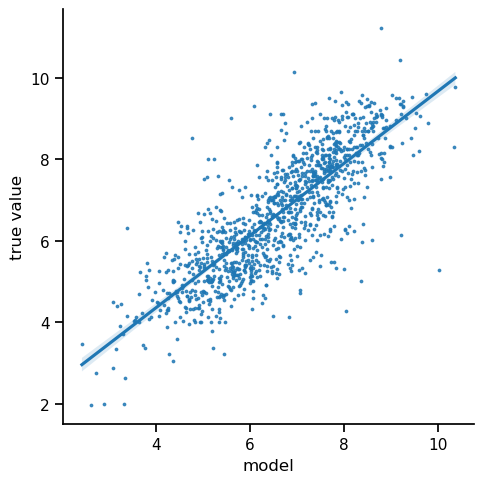

In [8]:
pred = model(x_test)
sns.lmplot(
    data=pd.DataFrame(
        {
            "model": pred.flatten().detach().numpy(),
            "true value": y_test.flatten().detach().numpy(),
        }
    ),
    x="model",
    y="true value",
    scatter_kws={"s": 3},
)

# mean absolute error
mae_single_model = torch.abs(pred - y_test).sum().item()

# mean squared error
mse_single_model = ((pred - y_test) ** 2).sum().item()

display(Markdown(f"The mean absolute error is {mae_single_model:.2f} and the mean squared error is {mse_single_model:.2f}."))

We observe a reasonable correlation between the predicted pIC50 and the measured value.
Apparantly, out model has learned how to extract 

### Ensembles - Training a model multiple times

In [9]:
ensemble_size = 20
ensemble = []
for _ in tqdm.tqdm(range(ensemble_size)):
    training_data = TensorDataset(x_train, y_train)
    training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
    model = create_and_fit_model(
        training_loader,
        test_loader,
    )
    ensemble.append(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.02s/it]


In [10]:
preds = torch.stack([model(x_test) for model in ensemble]).reshape(ensemble_size, len(x_test))

We now have the predictions over all ensembles and test samples in the matrix `pred`. We can compute basic statistics for each point of test data, such as mean and variance. The variance or standard deviation is used as an uncertainty estimate of the prediction.

In [37]:
stds = preds.std(0)
var = preds.var(0)
mean = preds.mean(0)
mae = torch.abs(mean - y_test.flatten()).sum()
mse = torch.sum((mean - y_test.flatten()) ** 2)

Now, it is interesting to compare the ensemble mean as a predictor to single model predictor above.

The mean absolute error decreased from 775.74 to 730.23. The mean squared error decreased from 904.44 to 858.07.

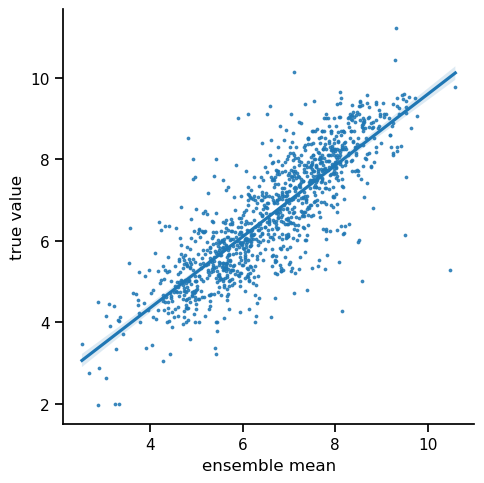

In [38]:
sns.lmplot(
    pd.DataFrame(
        {
            "ensemble mean": mean.detach().numpy(),
            "true value": y_test.flatten().detach().numpy(),
        }
    ),
    x="ensemble mean",
    y="true value",
    scatter_kws={"s": 3},
)

display(
    Markdown(
        f"The mean absolute error decreased from {mae_single_model:.2f} to {mae:.2f}. The mean squared error decreased from {mse_single_model:.2f} to {mse:.2f}."
    )
)

As we can see, the predictive quality on the test set increased.
Originally model ensembles were introduced as a means of improving prediction quality. ___CITATION___
Intuitively, this is achieved by mitigating the outliers of single models.

#### Coverage of confidence intervals

For each confidence level, we can compute confidence intervals based on the standard deviations, we get out of our model ensemble.
According to the definition of the confidence interval for level $p$, the interval should cover the actual value with probability $p$.
Therefore, if we plot all hit ratios over the test for all levels in $[0,1]$, we ideally would end up with a perfect diagonal (the identiy function).

In [13]:
confidences = np.linspace(0, 1)

hits = []
for c in confidences:
    delta = stds * norm.ppf(0.5 + c / 2) / np.sqrt(ensemble_size)
    a = np.array((mean - delta < y_test.flatten()) & (mean + delta > y_test.flatten())).astype(int)
    hits.append(a.sum() / len(a))

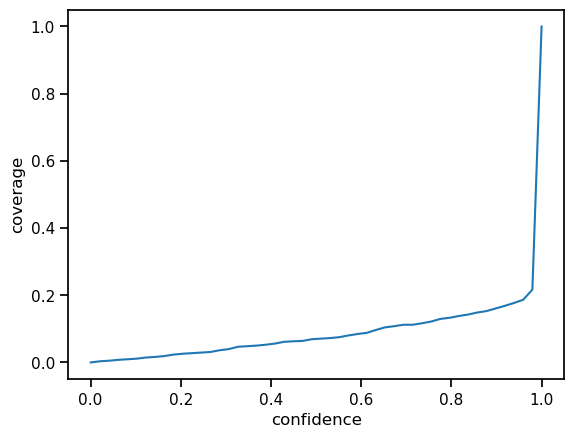

In [14]:
plt.plot(confidences, hits)
plt.ylabel("coverage")
plt.xlabel("confidence")
plt.yscale("linear")

#### Calibration

First, we compute the confidence curve on a small, dedicated part of the test set. Based on the confidence curve, we compute an adjustment factor for the estimated standard deviation. This process can be refined by computing a more complex transformation. For example, one could compute such a factor for any number of _bins_, i.e. intervals confidences.

In [15]:
num_calib = 100
preds_calibration = torch.stack([model(x_test[:num_calib]) for model in ensemble]).reshape(
    ensemble_size, num_calib
)

stds_calibration = preds_calibration.std(0)
mean_calibration = preds_calibration.mean(0)
confidences = np.linspace(0, 1)
hits_calibration = []
for c in confidences:
    delta = stds_calibration * norm.ppf(0.5 + c / 2) / np.sqrt(ensemble_size)
    a = np.array(
        (mean_calibration - delta < y_test[:num_calib].flatten())
        & (mean_calibration + delta > y_test[:num_calib].flatten())
    ).astype(int)
    hits_calibration.append(a.sum() / len(a))
calibration_adjustment = (confidences / hits_calibration)[1:-1]
calibration_adjustment = calibration_adjustment[calibration_adjustment != torch.inf].mean()

The constant calibration adjustment factor `calibration_adjustment` is used to compute confidence intervals.
The resulting confidence curve is now much better calibrated.
That means, it is close to the identity function.

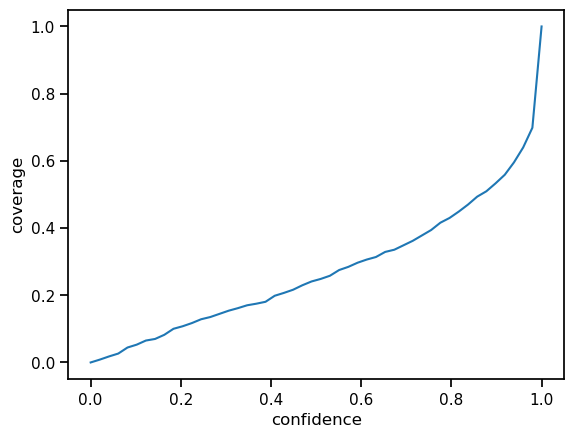

In [16]:
hits = []
for c in confidences:
    delta = (calibration_adjustment * stds * norm.ppf(0.5 + c / 2) / np.sqrt(len(ensemble)))[
        num_calib:
    ]
    a = np.array(
        (mean[num_calib:] - delta < y_test[num_calib:].flatten())
        & (mean[num_calib:] + delta > y_test[num_calib:].flatten())
    ).astype(int)
    hits.append(a.sum() / len(a))

plt.plot(confidences, hits)
plt.ylabel("coverage")
plt.xlabel("confidence")
plt.yscale("linear")

Much better! To get an even better calibration we could use more sophisticated calibration methods. For example, we could use an interval-based scheme. Especially if the curve is not consistent in over- or under-estimation of confidence, such a flexible scheme is more appropriate.

#### Ranking based evaluation
For now, we have not really looked at how useful our ensemble is to estimate uncertainty. Ideally, poor estimations would indicate that our prediction has -- at least potentially -- a higher error. To assess our uncertainty prediction in this sense, we can look at _confidence curves_. In this ranking-based scheme we order our estimates by decreasing uncertainty and look at the decrease in the total absolute error for a certain number of samples. We can then compare the resulting curve with a random baseline and the ideal curve.

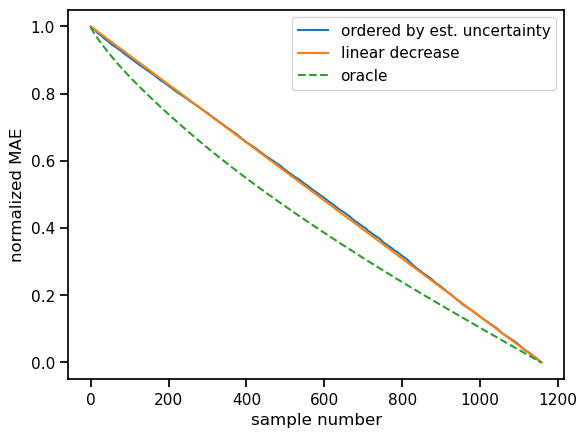

In [17]:
idcs_mae = torch.argsort(mae, 0, descending=True).flatten()
idcs_conf = torch.argsort(stds, 0, descending=True).flatten()
total_error = mae.sum().item()
plt.plot(
    (mae.sum() - torch.cumsum(mae[idcs_conf].flatten(), 0)).detach().numpy() / total_error,
    label="ordered by est. uncertainty",
)
plt.plot(
    [0, len(x_test)],
    [1, 0],
    label="linear decrease",
)
plt.plot(
    (mae.sum() - torch.cumsum(mae[idcs_mae], 0)).detach().numpy() / total_error,
    "--",
    label="oracle",
)
plt.legend()
plt.xlabel("sample number")
plt.ylabel("normalized MAE");

Ideally, the blue curve, i.e. our uncertainty estimates would be somewhere in between the random baseline and the ideal one. Unfortunately, our result is rather inconsistent.
Therefore, our uncertainty estimation is not very useful. This problem is not atypical. Often, more variety is necessary in the model ensemble.
Below we create more variety by bootstrapping and aggregating the training data.
Another way would be, to vary the model itself in some way within the ensemble.

### Bagging ensemble - Training a model with varying data

To capture the uncertainty better, we need to introduce more variety in the ensemble.
Instead of just varying training runs, we additionally vary the training data.
This is done by _bootstrapping and aggregating_ (_bagging_) the data:
For each run, we resample with replacement.

In [18]:
ensemble_size = 20
ensemble_bagg = []
for _ in tqdm.tqdm(range(ensemble_size)):
    idcs = torch.randint(low=0, high=len(x_train), size=(len(x_train),))
    x_train_resample = x_train[idcs]
    y_train_resample = y_train[idcs]
    training_data = TensorDataset(x_train_resample, y_train_resample)
    training_loader = DataLoader(training_data, batch_size=64)

    model = create_and_fit_model(
        training_loader,
        test_loader,
    )
    ensemble_bagg.append(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.79s/it]


Now, that all ensembles are trained, we compute the test set predictions of all ensemble members.

In [19]:
preds_bagg = torch.stack([model(x_test) for model in ensemble_bagg]).reshape(
    ensemble_size, len(x_test)
)

Again, we compute basic statistics on our ensemble predictions.

In [57]:
stds_bagg = preds_bagg.std(0)
var_bagg = preds_bagg.var(0)
mean_bagg = preds_bagg.mean(0)
mae_bagg = torch.abs(mean_bagg - y_test.flatten())
mse_bagg = (mean_bagg - y_test.flatten()) ** 2

The mean absolute error is 799.60 and the mean squared error is 944.34.

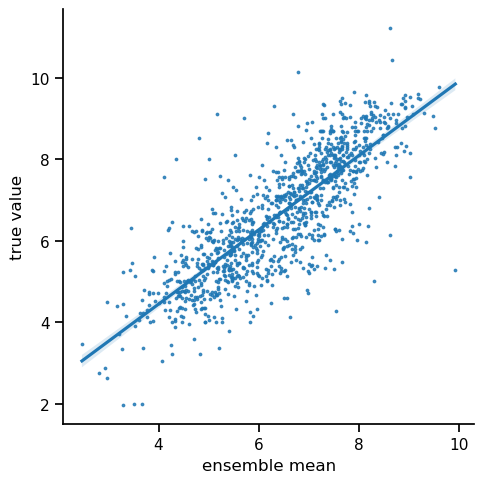

In [58]:
sns.lmplot(
    pd.DataFrame(
        {
            "ensemble mean": mean_bagg.detach().numpy(),
            "true value": y_test.flatten().detach().numpy(),
        }
    ),
    x="ensemble mean",
    y="true value",
    scatter_kws={"s": 3},
)

display(Markdown(f"The mean absolute error is {mae_bagg.sum():.2f} and the mean squared error is {mse_bagg.sum():.2f}."))

#### Calibration

In [59]:
num_calib = 100
preds_calibration = torch.stack([model(x_test[:num_calib]) for model in ensemble_bagg]).reshape(
    ensemble_size, num_calib
)

stds_calibration = preds_calibration.std(0)
mean_calibration = preds_calibration.mean(0)
confidences = np.linspace(0, 1)
hits_calibration = []
for c in confidences:
    delta = stds_calibration * norm.ppf(0.5 + c / 2) / np.sqrt(ensemble_size)
    a = np.array(
        (mean_calibration - delta < y_test[:num_calib].flatten())
        & (mean_calibration + delta > y_test[:num_calib].flatten())
    ).astype(int)
    hits_calibration.append(a.sum() / len(a))
calibration_adjustment_bagg = (confidences / hits_calibration)[1:-1]
calibration_adjustment_bagg = calibration_adjustment_bagg[
    calibration_adjustment_bagg != torch.inf
].mean()

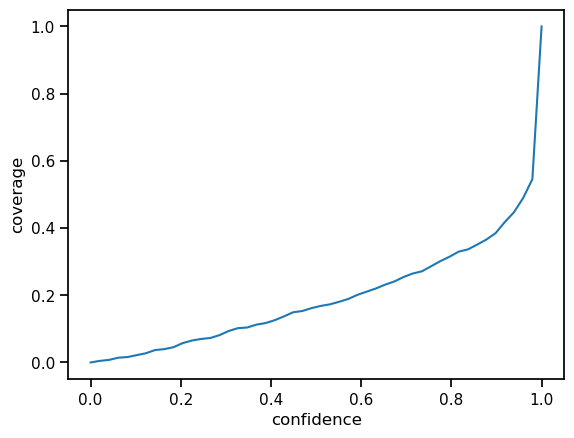

In [60]:
hits = []
for c in confidences:
    delta = (calibration_adjustment_bagg * stds * norm.ppf(0.5 + c / 2) / np.sqrt(len(ensemble)))[
        num_calib:
    ]
    a = np.array(
        (mean_bagg[num_calib:] - delta < y_test[num_calib:].flatten())
        & (mean_bagg[num_calib:] + delta > y_test[num_calib:].flatten())
    ).astype(int)
    hits.append(a.sum() / len(a))

plt.plot(confidences, hits)
plt.ylabel("coverage")
plt.xlabel("confidence")
plt.yscale("linear")

In [61]:
confidences = np.linspace(0, 1)
hits_bagg = []
for c in confidences:
    delta = (
        calibration_adjustment_bagg
        * stds_bagg[100:]
        * norm.ppf(0.5 + c / 2)
        / np.sqrt(len(ensemble_bagg))
    )
    a = np.array(
        (mean_bagg[100:] - delta < y_test[100:]) & (mean_bagg[100:] + delta > y_test[100:])
    ).astype(int)
    hits_bagg.append(a.sum() / len(a))

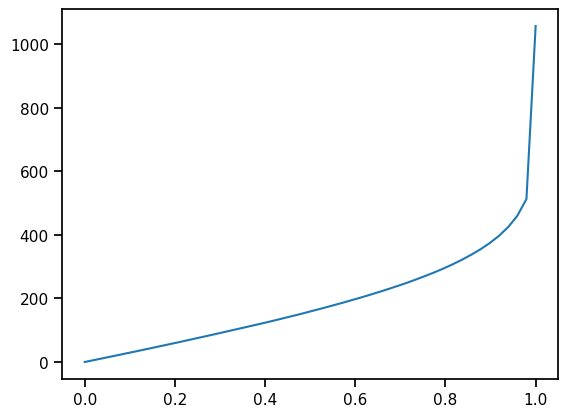

In [62]:
plt.plot(confidences, hits_bagg)
plt.yscale("linear")

### Ranking based evaluation
We now repeat the ranking based evaluation from above. That is, we plot the confidence curve against the constantly decreasing baseline and the optimal solution (oracle).

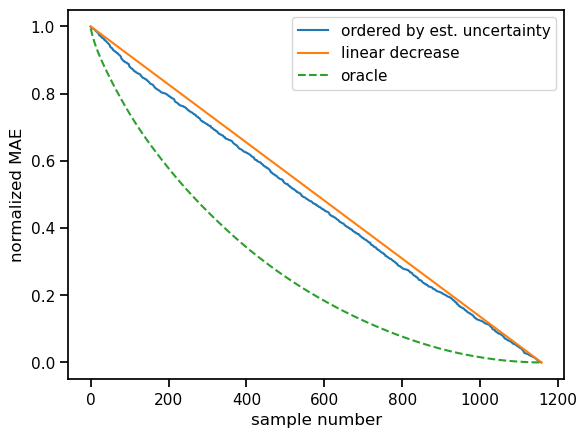

In [63]:
idcs_mae = torch.argsort(mae_bagg, 0, descending=True).flatten()
idcs_conf = torch.argsort(stds_bagg, 0, descending=True).flatten()
total_error = mae_bagg.sum().item()
plt.plot(
    (total_error - torch.cumsum(mae_bagg[idcs_conf].flatten(), 0)).detach().numpy() / total_error,
    label="ordered by est. uncertainty",
)
plt.plot(
    [0, len(x_test)],
    [1, 0],
    label="linear decrease",
)
plt.plot(
    (total_error - torch.cumsum(mae_bagg[idcs_mae], 0)).detach().numpy() / total_error,
    "--",
    label="oracle",
)
plt.legend()
plt.xlabel("sample number")
plt.ylabel("normalized MAE");

We observe a consistent improvement over the baseline. This means, the uncertainty
estimates help us getting an impression of estimate quality.
Poorer estimates more likely have a higher estimated uncertainty than the better ones.

### Test data augmentation

In [ ]:
N_AUG = 250

x_test_aug = torch.repeat_interleave(x_test, N_AUG, dim=0)

mutations = torch.rand_like(x_test_aug) < 0.01
x_test_aug = torch.logical_xor(mutations, x_test_aug)

x_test_aug = torch.tensor(x_test_aug, dtype=torch.float32)

In [ ]:
pred = model(x_test_aug)
pred = pred.reshape(-1, N_AUG, 1)
((pred.mean(1) - y_test) ** 2).sum()

In [ ]:
stds_aug = pred.std(1)
mae_aug = torch.abs(pred.mean(1) - y_test)

In [ ]:
torch.cumsum(mae_aug[torch.argsort(stds_aug, 0, descending=True).flatten()].flatten(), 0)

In [ ]:
idcs_mae = torch.argsort(mae_aug, 0, descending=True).flatten()
idcs_conf = torch.argsort(stds_aug, 0, descending=True).flatten()
total_err = mae_aug.sum().item()
plt.plot(
    (total_err - torch.cumsum(mae_aug[idcs_conf].flatten(), 0)).detach().numpy() / total_err,
    label="ordered by est. uncertainty",
)
plt.plot(
    [0, len(x_test)],
    [1, 0],
    label="linear decrease",
)
plt.plot(
    (total_err - torch.cumsum(mae_aug[idcs_mae].flatten(), 0)).detach().numpy() / total_err,
    "--",
    label="oracle",
)
plt.legend()
plt.xlabel("sample number")
plt.ylabel("normalized MAE");

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question